In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


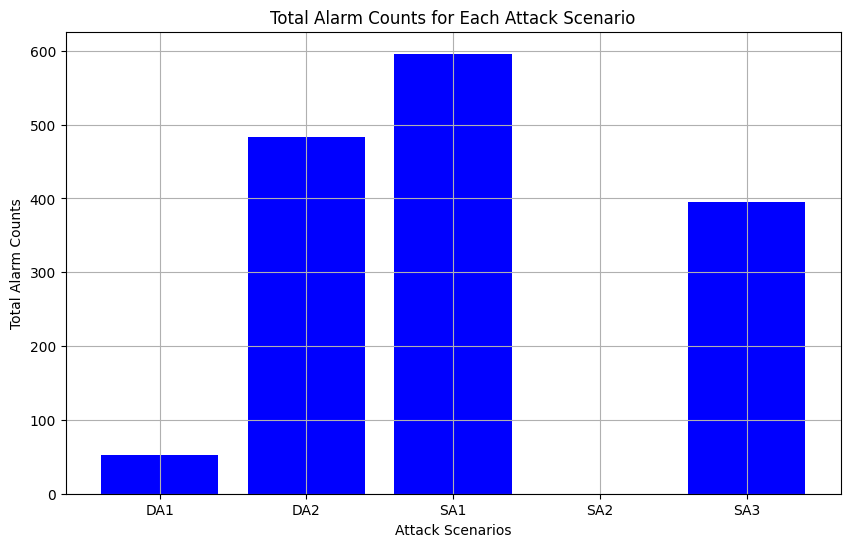

In [6]:
def pasad_ssa_analysis(file_paths, scenario_names, N=2000, L=24, start_train_idx=0, end_train_idx=2000, test_start_idx=2000):
    """
    Perform PASAD analysis using SSA and evaluate the total alarm count for multiple scenarios.

    Parameters:
    -----------
    file_paths : list of str
        List of paths to CSV files containing the dataset for each attack scenario.
    scenario_names : list of str
        List of short names for each scenario (e.g., 'DA1', 'DA2', 'SA1', etc.).
    N : int, optional
        Number of initial samples for training (default is 2000).
    L : int, optional
        Lag parameter for trajectory matrix (default is 24).
    start_train_idx : int, optional
        Start index for the training data (default is 0).
    end_train_idx : int, optional
        End index for the training data (default is 2000).
    test_start_idx : int, optional
        Start index for the test data (default is 2000).

    Returns:
    --------
    alarm_counts : dict
        Dictionary with scenario names as keys and total alarm counts as values.
    """

    def compute_departure_score(test_vector, U_r, center):
        # Project the test vector onto the signal subspace
        projected_test_vector = U_r.T @ test_vector
        # Compute the Euclidean distance from the center
        departure_score = np.linalg.norm(projected_test_vector - center) ** 2
        return departure_score

    alarm_counts = {}

    for file_path, scenario_name in zip(file_paths, scenario_names):
        # Load the dataset
        data = pd.read_csv(file_path)

        # Split the data into training and testing sets
        train_data = data.iloc[start_train_idx:end_train_idx, 1].values  # Using measurements for training
        test_data = data.iloc[test_start_idx:, 1].values  # Using remaining data for testing

        # Create the trajectory matrix for training data
        K = N - L + 1  # Number of lagged vectors
        trajectory_matrix = np.zeros((L, K))

        # Construct the lagged vectors for the trajectory matrix
        for i in range(K):
            trajectory_matrix[:, i] = train_data[i:i + L]

        # Perform Singular Value Decomposition on the trajectory matrix
        U, Sigma, VT = np.linalg.svd(trajectory_matrix, full_matrices=False)

        # Select the top 'r' components based on singular values (choosing r=1 for simplicity)
        r = 1
        U_r = U[:, :r]

        # Project the lagged training vectors onto the signal subspace
        projected_train_vectors = U_r.T @ trajectory_matrix

        # Compute the center of the projected vectors
        center = (np.min(projected_train_vectors, axis=1) + np.max(projected_train_vectors, axis=1)) / 2

        # Create train vectors and compute departure scores
        train_departure_scores = []
        for i in range(len(train_data) - L + 1):
            train_vector = test_data[i:i + L]
            score = compute_departure_score(train_vector, U_r, center)
            train_departure_scores.append(score)

        # Create test vectors and compute departure scores
        test_departure_scores = []
        for i in range(len(test_data) - L + 1):
            test_vector = test_data[i:i + L]
            score = compute_departure_score(test_vector, U_r, center)
            test_departure_scores.append(score)

        # Convert scores to a numpy array for easier handling
        train_departure_scores = np.array(train_departure_scores)
        test_departure_scores = np.array(test_departure_scores)

        # Calculate the threshold for attack detection based on maximum score in training data
        threshold = np.max(train_departure_scores)

        # Detect attack points: indices where departure scores exceed the threshold
        attack_indices = np.where(test_departure_scores > threshold)[0]

        # Store the total number of alarms for the current scenario
        alarm_counts[scenario_name] = len(attack_indices)

    # Plot the total alarm counts for each scenario
    scenarios = list(alarm_counts.keys())
    counts = list(alarm_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(scenarios, counts, color='blue')
    plt.title('Total Alarm Counts for Each Attack Scenario')
    plt.xlabel('Attack Scenarios')
    plt.ylabel('Total Alarm Counts')
    plt.grid(True)
    plt.show()

    return alarm_counts

# File paths and scenario names
file_paths = [
    'DataFiles/TE/xmv10_359_data_1.csv', 
    'DataFiles/TE/xmeas7_zero_data_1.csv',
    'DataFiles/TE/xmv9_hundred_data_1.csv', 
    'DataFiles/TE/xmv6_twentyeight_data_1.csv',
    'DataFiles/TE/xmeas10_001_data_1.csv'
]

# Corresponding short scenario names
scenario_names = ['DA1', 'DA2', 'SA1', 'SA2', 'SA3']

# Run analysis with the updated code
alarm_counts = pasad_ssa_analysis(file_paths, scenario_names, N=2000, L=24, start_train_idx=0, end_train_idx=2000, test_start_idx=2000)
